<a href="https://colab.research.google.com/github/joony0512/Deep_Learning_Class/blob/main/Part5/P5_Ch06_CH06_07_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNN SeqSeq

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/#fastcampus
!pwd

!ls

/content/drive/MyDrive/#fastcampus
/content/drive/MyDrive/#fastcampus
 config_utils.py      data_utils.py   requirements.txt
 config_utils_tf.py   __init__.py     runs
 config.yaml	      logs	     'runs(torch)'
 custom_math.py       models	      wandb
 data		      __pycache__    '[강의자료]-노트북-ipynb-파일'


In [ ]:
import os
import sys
sys.path.append('/content/drive/MyDrive/#fastcampus')
drive_project_root = '/content/drive/MyDrive/#fastcampus'
!pip install -r '/content/drive/MyDrive/#fastcampus/requirements.txt'

In [ ]:
!pip install tensorflow-addons
!pip install wandb
!pip install omegaconf
!pip install hydra-core==1.1


In [6]:
from typing import Optional
from typing import List
from typing import Dict
from typing import Tuple

import io
import re
import unicodedata
import time
from datetime import datetime

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.pyplot as ticker
from omegaconf import OmegaConf
from omegaconf import DictConfig
import hydra
from hydra.core.config_store import ConfigStore

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

import wandb


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [7]:
from data_utils import dataset_split
from config_utils_tf import flatten_dict
from config_utils_tf import register_config
from config_utils_tf import get_optimizer_element
from config_utils_tf import get_callbacks


In [8]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [9]:
!nvidia-smi

Sun Jul 16 10:01:49 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    12W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 데이터 및 데이터로더 정의 및 전처리

In [10]:
# Download the file
data_root = os.path.join(drive_project_root, "data", "anki_spa_eng")
if not os.path.exists(data_root):
    os.mkdir(data_root)

data_path = os.path.join(data_root, "spa-eng.zip")

path_to_zip = tf.keras.utils.get_file(
    data_path,
    origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True,
    cache_dir = data_root)

path_to_file = os.path.join(
    os.path.dirname(path_to_zip),
    "datasets",
    "spa-eng",
    "spa.txt",
)

print(path_to_file)

/content/drive/MyDrive/#fastcampus/data/anki_spa_eng/datasets/spa-eng/spa.txt


In [11]:
# 전처리

def unicode_to_ascii(s):
    return "".join(c for c in unicodedata.normalize("NFD", s) if unicodedata.category(c) !="Mn")

def preprocessing_sentence(w):
    # ascii 로 변환 및 소문자로 변환
    w = unicode_to_ascii(w.lower().strip())
    # 단어와 단어 뒤에 오는 구두점(.) 사이에 공백을 생성
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # (a-z, A-Z, [?.!,¿] 을 제외한 모든 것을 공백으로 대체)
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    w = w.strip()

    # 모델의 앞뒤에 start, end 토큰 추가
    w = "<start> "+ w +" <end>"
    return w

def create_dataset(path : str, num_examples : Optional[int]=None):
    lines = io.open(path, encoding = "UTF-8").read().strip().split("\n")

    word_pairs =[[preprocessing_sentence(w) for w in l.split("\t")] for l in lines[:num_examples] ]
    # None인경우 다가져오고 숫자가 있는경우 숫자만큼만 가져온다.
    return zip(*word_pairs)


en, sp = create_dataset(path_to_file)
print(en[-1])
print(sp[-1])

<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>


In [12]:
# Tokenizer 정의, 최종적으로 쓸 데이터 정의.

def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters ="")
    lang_tokenizer.fit_on_texts(lang)

    tensor = lang_tokenizer.texts_to_sequences(lang)
    tensor = pad_sequences(tensor, padding = 'post')

    return tensor, lang_tokenizer

def load_dataset(path, num_examples = None):

    tar_lang, src_lang = create_dataset(path, num_examples) # en, sp

    src_tensor, src_tokenizer = tokenize(src_lang)
    tar_tensor, tar_tokenizer = tokenize(tar_lang)

    return src_tensor, tar_tensor, src_tokenizer,tar_tokenizer

# 언어 데이터셋을 불러오기
num_examples = 30000
src_tensor, tar_tensor, src_tokenizer,tar_tokenizer = load_dataset(
    path_to_file, num_examples
)

max_tar_len, max_src_len = tar_tensor.shape[1], src_tensor.shape[1]

src_vocab_size = len(src_tokenizer.word_index) +1
tar_vocab_size = len(tar_tokenizer.word_index) +1

print(src_vocab_size)
print(tar_vocab_size)


9414
4935


In [13]:
print(tar_tensor[-2])
print(tar_tokenizer.word_index)

for i in tar_tensor[-2]:
    if i ==0:
        break
    print(i, tar_tokenizer.index_word[i])

[  1  16  38 369 107  39   3   2   0   0   0]
{'<start>': 1, '<end>': 2, '.': 3, 'i': 4, 'tom': 5, 'you': 6, '?': 7, 'is': 8, 'a': 9, 'it': 10, 's': 11, 't': 12, 'the': 13, 'he': 14, 'to': 15, 'we': 16, 'me': 17, 'm': 18, 'this': 19, 'that': 20, 'my': 21, 'do': 22, 're': 23, 'are': 24, 'can': 25, 'was': 26, 'she': 27, 'they': 28, 'have': 29, 'don': 30, 'your': 31, 'what': 32, 'in': 33, 'not': 34, 'like': 35, 'go': 36, '!': 37, 'll': 38, 'here': 39, 'be': 40, 'him': 41, 'did': 42, 'know': 43, 'on': 44, 'mary': 45, 'let': 46, 'want': 47, 'very': 48, ',': 49, 'up': 50, 'has': 51, 'how': 52, 'come': 53, 'for': 54, 'at': 55, 'please': 56, 'there': 57, 'now': 58, 'of': 59, 'who': 60, 'his': 61, 'am': 62, 'need': 63, 'get': 64, 've': 65, 'no': 66, 'all': 67, 'her': 68, 'good': 69, 'just': 70, 'where': 71, 'see': 72, 'help': 73, 'out': 74, 'will': 75, 'got': 76, 'love': 77, 'too': 78, 'an': 79, 'with': 80, 'us': 81, 'why': 82, 'car': 83, 'one': 84, 'so': 85, 'stop': 86, 'didn': 87, 'look': 88,

## 모델정의


In [31]:
class GRUEncoder(tf.keras.Model):
    def __init__(self, cfg: DictConfig):
        super().__init__()
        self.cfg = cfg
        self.enc_emb = tf.keras.layers.Embedding(
            cfg.data.src.vocab_size,
            cfg.model.enc.embed_size
        )
        self.enc_gru = tf.keras.layers.GRU(
            cfg.model.enc.rnn.units,
            return_state = True,
            return_sequences= True,
            recurrent_initializer= "glorot_uniform"
        )

    def call(self, src_tokens, state = None, training =False):
        embed_enc = self.enc_emb(src_tokens)
        enc_outputs, enc_states = self.gru(
            embed_enc, initial_state = state
        )
        return enc_outputs, enc_states

class GRUDecoder(tf.keras.Model):
    def __init__(self, cfg : DictConfig):
        super().__init__()
        self.cfg = cfg
        self.dec_emb = tf.keras.layers.Embedding(
            cfg.data.tar.vocab_size,
            cfg.model.dec.embed_size
        )
        self.dec_gru = tf.keras.layers.GRU(
            cfg.model.dec.rnn.units,
            return_state = True,
            return_sequences= True,
            recurrent_initializer= "glorot_uniform"
        )
        self.fc = tf.keras.layers.Dense(cfg.data.tar.vocab_size)


    def call(self, tar_tokens, state = None, training =False):
        embed_dec = self.dec_emb(tar_tokens)
        dec_outputs, dec_states = self.gru(
            embed_dec, initial_state = state
        )
        final_outputs = self.fc(dec_outputs)
        return final_outputs, dec_states, None # None은 추후 attention등 추가시 인터페이스 통일

## configuration 정의

In [32]:
# data configuration
data_anki_spa_eng_cfg ={
    "name" : "anki_spa_eng_cfg",
    "src" : {
        "vocab_size" : src_vocab_size,
        "max_len" : max_src_len,
    },
    "tar" : {
        "vocab_size" : tar_vocab_size,
        "max_len" : max_tar_len,
    },
    "train_val_test_split_ratio" : [0.8, 0.1, 0.1],
    "train_val_shuffle" : True,
}

# model configuration
model_translate_rnn_seq2seq_cfg ={
    "name" : "RNNSeq2Seq",
    "enc" : {
        "embed_size" : 256,
        "rnn" : {
            "units" : 1024,
        },
    },
    "dec" : {
        "embed_size" : 256,
        "rnn" : {
            "units" : 1024,
        },
    },

 }

# optimizer_configs

adam_warmup_lr_sch_opt_cfg  ={
    "optimizer" :{
        "name" : "Adam",
        "other_kwargs" :{}, # 빈값이면 기본이 들어감
    },
    "lr_scheduler":{
        "name" : "LinearWarmupLRSchedule",
        "kwargs" : {
            "lr_peak" : 1e-3,
            "warmup_end_steps" : 1500,
        }
    }
}

radam_no_lr_sch_opt_cfg  ={ # Radam은 굳이 스케줄러 필요 없음
    "optimizer" :{
        "name" : "RectifiedAdam",
        "learning_rate" : 1e-3,
        "other_kwargs" :{}, # 빈값이면 기본이 들어감
    },
    "lr_scheduler": None
}

# train configs

train_cfg : dict ={
    "train_batch_size" : 128,
    "val_batch_size" : 32,
    "test_batch_size" : 32,
    "max_epochs" : 50,
    "distribute_strategy" : "MirroredStrategy",
    "teacher_forcing_ratio" : 0.5,
}

_merged_cfg_presets ={

    "rnn_translate_spa_eng_radam" :{
        "data" : data_anki_spa_eng_cfg,
        "model" : model_translate_rnn_seq2seq_cfg,
        "opt" : radam_no_lr_sch_opt_cfg,
        "train" : train_cfg,

    }
}

### hydra composition ###
# clear hydra instance.
hydra.core.global_hydra.GlobalHydra.instance().clear()

# resister preset cfgs
register_config(_merged_cfg_presets)

# initializing
hydra.initialize(config_path =None)

using_config_key = "rnn_translate_spa_eng_radam"
cfg = hydra.compose(using_config_key)

# define & override log_cfg
model_name = cfg.model.name
run_dirname ='dnn-tutorial-spa-eng-translate-runs-tf'
run_name = f'{datetime.now().isoformat(timespec="seconds")} -{using_config_key}-{model_name}'
log_dir = os.path.join(drive_project_root, 'runs', run_dirname, run_name)




log_cfg ={
    "run_name" : run_name,
    "checkpoint_filepath" : os.path.join(log_dir , "model"),
    "tensorboard_log_dir" : log_dir ,
    "callbacks" : {
        "TensorBoard" :{
          "log_dir" :log_dir,
          "update_freq" :50,
        },
        "EarlyStopping" : {
          "patience" : 30,
          "verbose" : True,
        },
    },
    "wandb" : {
        "project" : "dnn-tutorial-spa-eng-translate-runs-tf",
        "name" : run_name,
        "tags" : ["dnn-tutorial-spa-eng-translate-runs-tf"],
        "reinit" : True,
        "sync_tensorboard" : True
    },

}

# unlock struct of config & set log config
OmegaConf.set_struct(cfg, False)
cfg.log =log_cfg

# relock config
OmegaConf.set_struct(cfg, True)
print(OmegaConf.to_yaml(cfg))

# save yaml
# with open(os.path.join(log_dir, "config.yaml")) as f :
with  open("config.yaml", "w") as f :
  OmegaConf.save(cfg, f)

data:
  name: anki_spa_eng_cfg
  src:
    vocab_size: 9414
    max_len: 16
  tar:
    vocab_size: 4935
    max_len: 11
  train_val_test_split_ratio:
  - 0.8
  - 0.1
  - 0.1
  train_val_shuffle: true
model:
  name: RNNSeq2Seq
  enc:
    embed_size: 256
    rnn:
      units: 1024
  dec:
    embed_size: 256
    rnn:
      units: 1024
opt:
  optimizer:
    name: RectifiedAdam
    learning_rate: 0.001
    other_kwargs: {}
  lr_scheduler: null
train:
  train_batch_size: 128
  val_batch_size: 32
  test_batch_size: 32
  max_epochs: 50
  distribute_strategy: MirroredStrategy
  teacher_forcing_ratio: 0.5
log:
  run_name: 2023-07-16T10:46:21 -rnn_translate_spa_eng_radam-RNNSeq2Seq
  checkpoint_filepath: /content/drive/MyDrive/#fastcampus/runs/dnn-tutorial-spa-eng-translate-runs-tf/2023-07-16T10:46:21
    -rnn_translate_spa_eng_radam-RNNSeq2Seq/model
  tensorboard_log_dir: /content/drive/MyDrive/#fastcampus/runs/dnn-tutorial-spa-eng-translate-runs-tf/2023-07-16T10:46:21
    -rnn_translate_spa_eng_

In [33]:
def get_distribute_strategy(strategy_name : str, **kwargs):
  return getattr(tf.distribute, strategy_name)(**kwargs)

distribute_strategy = get_distribute_strategy(cfg.train.distribute_strategy)

# dataloader

In [34]:
# data batchify 및 train/val/test split
dataset = tf.data.Dataset.from_tensor_slices((src_tensor, tar_tensor))
total_n = len(src_tensor)

print(cfg.data.train_val_test_split_ratio)
train_size = int(total_n * cfg.data.train_val_test_split_ratio[0])
val_size = int(total_n * cfg.data.train_val_test_split_ratio[1])
test_size = total_n - (train_size + val_size)

# split (train, val) (test) dataset
test_dataset = dataset.skip(train_size + val_size)
train_val_dataset = dataset.take(train_size + val_size)

if cfg.data.train_val_shuffle:
    train_val_dataset = train_val_dataset.shuffle(buffer_size = 1024)

train_dataset= train_val_dataset.take(train_size)
val_dataset = train_val_dataset.skip(train_size)

train_n, val_n, test_n = len(train_dataset), len(val_dataset), len(test_dataset)
print(train_n, val_n, test_n)
assert train_n + val_n + test_n == total_n

# batchfy (dataloader)
train_batch_size = cfg.train.train_batch_size
val_batch_size = cfg.train.val_batch_size
test_batch_size = cfg.train.test_batch_size

train_dataloader = train_dataset.batch(train_batch_size, drop_remainder=True)
val_dataloader = val_dataset.batch(val_batch_size, drop_remainder=True)
test_dataloader = test_dataset.batch(test_batch_size, drop_remainder=True)

[0.8, 0.1, 0.1]
24000 3000 3000


In [35]:
# 모델정의
def get_seq2seq_model(cfg : DictConfig):
  if cfg.model.name == "RNNSeq2Seq" :
    encoder = GRUEncoder(cfg)
    decoder = GRUDecoder(cfg)
    return encoder, decoder
  else:
    raise NotImplementedError()


In [36]:
# loss 정의

def loss_function(
    real,
    pred,
    loss_object =tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits = True, reduction = 'none')
    ) :
    # delete [pad] loss part with masks
    mask = tf.math.logical_not(
        tf.math.equal(real, 0)
    )
    _loss = loss_object(real, pred)

    mask = tf.cast(mask, dtype = _loss.dtype)
    _loss *= mask

    return tf.reduce_mean(_loss)

In [37]:
# get model
encoder, decoder = get_seq2seq_model(cfg)

# get optimizer
optimizer, scheduler = get_optimizer_element(
    cfg.opt.optimizer, cfg.opt.lr_scheduler
)

# checkpoints
checkpoint_prefix = cfg.log.checkpoint_filepath
checkpoint = tf.train.Checkpoint(
    optimizer = optimizer,
    encoder = encoder,
    decoder = decoder,
)

In [ ]:
# get callbacks
callbacks = get_callbacks(cfg.log)

# wandb setup
wandb.init(
    config = flatten_dict(cfg),
    **cfg.log.wandb
)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content/drive/MyDrive/\#fastcampus/runs/
model.fit(
    train_dataloader,
    validation_data = val_dataloader,
    epochs = cfg.train.max_epochs,
    callbacks =callbacks,
)


Launching TensorBoard...

## Model testing

In [ ]:
model.evaluate(test_dataloader)

100/100 [==============================] - 1s 5ms/step - loss: 0.3435 - accuracy: 0.8992


[0.34348130226135254, 0.8992000222206116]

In [ ]:
test_labels_list =[]
test_preds_list =[]
test_outputs_list =[]

for i, (test_images, test_labels) in enumerate(tqdm(test_dataloader, position =0, leave =True, desc='testing')):
  with mirrored_strategy.scope():
    test_outputs = model(test_images)
  test_preds = tf.argmax(test_outputs, 1)

  final_outs = test_outputs.numpy()
  test_outputs_list.extend(final_outs)
  test_preds_list.extend(test_preds.numpy())
  test_labels_list.extend(test_labels.numpy())

test_preds_list =np.array(test_preds_list)
test_labels_list = np.array(test_labels_list)

test_accuracy =np.mean(test_preds_list == test_labels_list)
print(f'\nacc: {test_accuracy*100}%')

testing: 100%|██████████| 100/100 [00:01<00:00, 54.22it/s]


acc: 89.92%


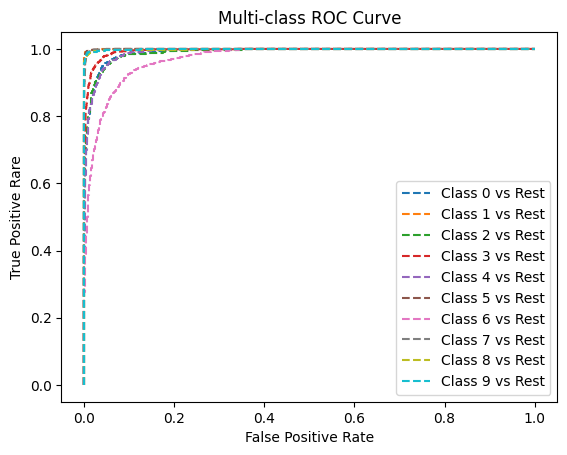

auc_score : 0.9931041944444445


In [ ]:
# ROC Curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr ={}
tpr ={}
thresh = {}
n_class =10

for i in range(n_class):
  fpr[i], tpr[i], thresh[i] =roc_curve(test_labels_list, np.array(test_outputs_list)[:,i], pos_label =i) #class별로 따로따로

#plot
for i in range(n_class):
  plt.plot(fpr[i], tpr[i], linestyle ='--', label=f'Class {i} vs Rest')
plt.title('Multi-class ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rare')
plt.legend(loc ='best')
plt.show()

auc_score = roc_auc_score(test_labels_list, test_outputs_list, multi_class ='ovo', average ='macro')
print(f'auc_score : {auc_score}')